In [139]:
import pickle
import sklearn
import modAL
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from modAL.uncertainty import uncertainty_sampling
import sys


import audio_decryption
import IPython.display

# 1. Read negative file into test and train #

In [158]:
neg_file= open("/home/amm1209/sonyc_distortion_classification/data/negative_xy_new.pickle", "rb")
negative_xy = pickle.load(neg_file)

In [159]:
negative_xy

array([['146', '14', '129', ..., '255', '0', 'b827eb4e7821'],
       ['154', '30', '171', ..., '255', '0', 'b827eb4e7821'],
       ['153', '25', '150', ..., '255', '0', 'b827eb4e7821'],
       ...,
       ['153', '25', '146', ..., '255', '0', 'b827eb9bed23'],
       ['153', '25', '152', ..., '255', '0', 'b827eb9bed23'],
       ['155', '23', '168', ..., '255', '0', 'b827eb429cd4']],
      dtype='<U21')

In [160]:
sens= []
for i in range(negative_xy.shape[0]):
    sens.append(negative_xy[i,-1])

In [161]:
unique_sensors = np.unique(sens)

In [162]:
unique_sensors

array(['b827eb0d8af7', 'b827eb0fedda', 'b827eb122f0f', 'b827eb1685c7',
       'b827eb2a1bce', 'b827eb429cd4', 'b827eb42bd4a', 'b827eb44506f',
       'b827eb4e7821', 'b827eb5895e9', 'b827eb815321', 'b827eb86d458',
       'b827eb8e2420', 'b827eb9bed23', 'b827ebad073b'], dtype='<U12')

In [163]:
negative_test = np.zeros((7*20,negative_xy.shape[1]-1))
negative_train = np.zeros((8*20,negative_xy.shape[1]-1))
j=0
k=0
for i in range(negative_xy.shape[0]):
    
    if negative_xy[i,-1]=='b827eb0d8af7' or negative_xy[i,-1]=='b827eb0fedda' or negative_xy[i,-1]=='b827eb122f0f' or negative_xy[i,-1]=='b827eb1685c7' or negative_xy[i,-1]=='b827eb2a1bce'or negative_xy[i,-1]=='b827eb429cd4' or negative_xy[i,-1]=='b827eb42bd4a':
        negative_test[j,:]= negative_xy[i,:-1]
        j=j+1
    else:
        negative_train[k,:]= negative_xy[i,:-1]
        k=k+1 

In [164]:
negative_train = negative_train.astype(int)

In [165]:
negative_train

array([[146,  14, 129, ...,  62, 255,   0],
       [154,  30, 171, ..., 158, 255,   0],
       [153,  25, 150, ..., 150, 255,   0],
       ...,
       [158,  29, 166, ...,  87, 255,   0],
       [153,  25, 146, ...,   0, 255,   0],
       [153,  25, 152, ...,   0, 255,   0]])

In [166]:
negative_test = negative_test.astype(int)

In [167]:
negative_test

array([[152,  24, 142, ...,  30, 255,   0],
       [162,  34, 157, ..., 255, 255,   0],
       [154,  28, 152, ..., 129, 255,   0],
       ...,
       [156,  25, 180, ...,   7, 255,   0],
       [153,  28, 170, ..., 124, 255,   0],
       [155,  23, 168, ...,  90, 255,   0]])

# 2. Read positive file into test and train #

In [168]:
positive_xy = pickle.load(open( "/home/amm1209/sonyc_distortion_classification/data/positive_xy_new.pickle", "rb" ))

In [169]:
positive_xy

array([['153', '17', '128', ..., '255', '1', 'b827eb429cd4'],
       ['150', '19', '127', ..., '255', '1', 'b827eb429cd4'],
       ['155', '18', '126', ..., '255', '1', 'b827eb429cd4'],
       ...,
       ['160', '20', '161', ..., '255', '1', 'b827eb42bd4a'],
       ['154', '20', '139', ..., '255', '1', 'b827eb42bd4a'],
       ['154', '21', '130', ..., '255', '1', 'b827eb42bd4a']],
      dtype='<U21')

In [170]:
positive_test = np.zeros((7*20,positive_xy.shape[1]-1))
positive_train = np.zeros((8*20,positive_xy.shape[1]-1))
j=0
k=0
for i in range(positive_xy.shape[0]):
    
    if positive_xy[i,-1]=='b827eb0d8af7' or positive_xy[i,-1]=='b827eb0fedda' or positive_xy[i,-1]=='b827eb122f0f' or positive_xy[i,-1]=='b827eb1685c7' or positive_xy[i,-1]=='b827eb2a1bce'or positive_xy[i,-1]=='b827eb429cd4' or positive_xy[i,-1]=='b827eb42bd4a':
        positive_test[j,:]= positive_xy[i,:-1]
        j=j+1
    else:
        positive_train[k,:]= positive_xy[i,:-1]
        k=k+1 

In [171]:
positive_train = positive_train.astype(int)

In [172]:
positive_train

array([[152,   7, 152, ..., 200, 255,   1],
       [151,  12, 155, ...,  87, 255,   1],
       [155,  17, 160, ...,   0, 255,   1],
       ...,
       [153,  22, 143, ..., 202, 255,   1],
       [157,  14, 162, ..., 163, 255,   1],
       [152,  21, 140, ..., 243, 255,   1]])

In [173]:
positive_test = positive_test.astype(int)

In [174]:
positive_test

array([[153,  17, 128, ..., 136, 255,   1],
       [150,  19, 127, ...,  76, 255,   1],
       [155,  18, 126, ..., 156, 255,   1],
       ...,
       [160,  20, 161, ..., 167, 255,   1],
       [154,  20, 139, ..., 255, 255,   1],
       [154,  21, 130, ..., 137, 255,   1]])

# 3. Concatenate negatives and positives in both test and train #

## 3.1. Concatenate train examples together ##

In [175]:
train = np.concatenate((positive_train, negative_train))

In [178]:
train

array([[152,   7, 152, ..., 200, 255,   1],
       [151,  12, 155, ...,  87, 255,   1],
       [155,  17, 160, ...,   0, 255,   1],
       ...,
       [158,  29, 166, ...,  87, 255,   0],
       [153,  25, 146, ...,   0, 255,   0],
       [153,  25, 152, ...,   0, 255,   0]])

## 3.2. Concatenate test examples together ##

In [179]:
test = np.concatenate((positive_test, negative_test))

In [180]:
test

array([[153,  17, 128, ..., 136, 255,   1],
       [150,  19, 127, ...,  76, 255,   1],
       [155,  18, 126, ..., 156, 255,   1],
       ...,
       [156,  25, 180, ...,   7, 255,   0],
       [153,  28, 170, ..., 124, 255,   0],
       [155,  23, 168, ...,  90, 255,   0]])

## 3.3. Shuffle data ##

In [181]:
np.random.shuffle(train)

In [182]:
np.random.shuffle(test)

## 3.4. Separate x and y ##

### 3.4.1. Separate training data ###

In [183]:
x_train = train[:,:-1]

In [184]:
x_train.shape

(320, 128)

In [185]:
y_train = train[:,-1]

In [186]:
y_train.shape

(320,)

### 3.4.2. Separate test data ###

In [187]:
x_test = test[:,:-1]

In [188]:
x_test.shape

(280, 128)

In [189]:
y_test = test[:,-1]

In [190]:
y_test.shape

(280,)

# 4. Read X_pool file #

In [191]:
pool_file= open("/home/amm1209/sonyc_distortion_classification/data/X_pool_10000.pickle", "rb")
X_pool = pickle.load(pool_file)

In [192]:
X_pool.shape

(9974, 128)

In [193]:
ids_file= open("/home/amm1209/sonyc_distortion_classification/data/id_pool_10000.pickle", "rb")
id_pool = pickle.load(ids_file)

In [194]:
id_pool.shape

(9974, 2)

In [195]:
sensor_id = []
time_stamp = []
frame = []
for i in range(len(id_pool)):
    sensor_timestamp = id_pool[i][0]
    if len(sensor_timestamp.decode("utf-8").split('_')) ==1:
        print(sensor_timestamp)
        sensor_id.append(sensor_timestamp.decode("utf-8").split('-')[0])
        time_stamp.append(float(sensor_timestamp.decode("utf-8").split('-')[1]))
    else:     
        sensor_id.append(sensor_timestamp.decode("utf-8").split('_')[0])
        time_stamp.append(float(sensor_timestamp.decode("utf-8").split('_')[1]))
    frame.append(int(id_pool[i][1].decode("utf-8")))


In [196]:
type(time_stamp[0])

float

# 5. Create classifier #

In [197]:
clf = RandomForestClassifier(n_estimators = 100)

In [198]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [199]:
pred = clf.predict(x_test)

In [200]:
sklearn.metrics.accuracy_score(y_test,pred)

0.95

# 6. Create Active Learner #

In [201]:
learner = ActiveLearner(
    estimator=clf,
    query_strategy=uncertainty_sampling,
    X_training=x_train, y_training=y_train
)

In [202]:
#set audio_path
#set **kwargs
audio_path = '/beegfs/work/sonyc/audio/'
url='https://decrypt-sonyc.engineering.nyu.edu/decrypt', 
cacert='CA.pem', 
cert='ana_elisa_data.pem',
key='aemm_key.pem'


In [208]:
n_queries = 50
n_instances = 10
accuracy = np.zeros(n_queries)
not_converged = True
count = 0
while not_converged:
    y = []
    query_idx, query_instance = learner.query(X_pool, n_instances=n_instances)
    print (query_idx)
    for i in range(n_instances):
        print(type(time_stamp[i]))
        IPython.display.display(audio_decryption.decrypt_and_load_audio(audio_path, 
                                                       sensor_id[query_idx[i]],
                                                       time_stamp[query_idx[i]], 
                                                       sample_rate=44100, 
                                                       frame=frame[query_idx[i]], 
                                                       url='https://decrypt-sonyc.engineering.nyu.edu/decrypt', 
                                                       cacert='CA.pem', 
                                                       cert='ana_elisa_data.pem',
                                                       key='aemm_key.pem'))
        y_new = input("Please input label for\nsensor_id = '%s'\ntimestamp = %s\nframe = %d (1 if noise is present, 0 if noise is not present)" % (sensor_id[query_idx[i]],time_stamp[query_idx[i]],frame[query_idx[i]]))
        y.append(int(y_new))
        
    print('ARRAY: ',y)
    learner.teach(
        X=X_pool[query_idx],
        y=np.array(y).reshape(-1, ))
    
    X_pool = np.delete(X_pool, query_idx, axis=0)
    id_pool = np.delete(id_pool, query_idx, axis=0)
    
    print('Accuracy after query no. %d: %f' % (count+1, learner.score(x_test, y_test)))
    
    accuracy[count]=learner.score(x_test, y_test)
    
    print(accuracy[count]-accuracy[count-1])
    #(accuracy[count]>=accuracy[count-1] and accuracy[count]-accuracy[count-1]<0.0001) or 
    if (accuracy[count]>=accuracy[count-1] and accuracy[count]-accuracy[count-1]<0.0001) or count == n_queries-1:
        not_converged = False
    count = count +1
print(accuracy)

[2585 2005 1767 5820 5780 5657  911 6105 2669 9730]
<class 'float'>


Please input label for
sensor_id = 'b827eb44506f'
timestamp = 1486142823.56
frame = 0 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb86d458'
timestamp = 1480927314.34
frame = 4 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb0d8af7'
timestamp = 1486408734.94
frame = 3 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827ebba613d'
timestamp = 1487889249.64
frame = 1 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb122f0f'
timestamp = 1499294828.89
frame = 9 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb5895e9'
timestamp = 1496716416.48
frame = 7 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb42bd4a'
timestamp = 1496217330.53
frame = 1 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb0fedda'
timestamp = 1495087192.81
frame = 3 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb0d8af7'
timestamp = 1485161492.79
frame = 6 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb9d0e7f'
timestamp = 1489315177.64
frame = 1 (1 if noise is present, 0 if noise is not present)0
ARRAY:  [1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
Accuracy after query no. 1: 0.953571
0.9535714285714286
[ 979 1517 7191 9595 1015  760 4412  509 3619 9563]
<class 'float'>


Please input label for
sensor_id = 'b827eb815321'
timestamp = 1480879841.44
frame = 1 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb2a1bce'
timestamp = 1492302898.11
frame = 5 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb539980'
timestamp = 1490865136.56
frame = 7 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb0d8af7'
timestamp = 1488682326.42
frame = 2 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb42bd4a'
timestamp = 1490157631.56
frame = 4 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827ebc6dcc6'
timestamp = 1494421826.29
frame = 2 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb73e772'
timestamp = 1499678617.72
frame = 9 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb2a1bce'
timestamp = 1499114784.3
frame = 0 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb429cd4'
timestamp = 1490494793.16
frame = 9 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827ebf31214'
timestamp = 1495786700.22
frame = 8 (1 if noise is present, 0 if noise is not present)0
ARRAY:  [1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Accuracy after query no. 2: 0.964286
0.010714285714285676
[2312 1497 8533 1172 6703 6790 6452 4267  908 1898]
<class 'float'>


Please input label for
sensor_id = 'b827eb132382'
timestamp = 1483937616.66
frame = 2 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827ebe1fe4b'
timestamp = 1485726370.28
frame = 6 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb42bd4a'
timestamp = 1493804548.08
frame = 8 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb7b2c3e'
timestamp = 1488211482.8
frame = 7 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb539980'
timestamp = 1499798247.65
frame = 7 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb122f0f'
timestamp = 1499943981.14
frame = 9 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb0fedda'
timestamp = 1498749411.51
frame = 5 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb429cd4'
timestamp = 1497906509.46
frame = 7 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb2a1bce'
timestamp = 1484932922.43
frame = 7 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb1685c7'
timestamp = 1496692632.97
frame = 4 (1 if noise is present, 0 if noise is not present)1
ARRAY:  [0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Accuracy after query no. 3: 0.953571
-0.010714285714285676
[5719 3805 1984 2972 7943 2053 2381 3021 5748 2905]
<class 'float'>


Please input label for
sensor_id = 'b827eb0fedda'
timestamp = 1491298319.05
frame = 5 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb905497'
timestamp = 1497636061.8
frame = 9 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb2c65db'
timestamp = 1481296704.19
frame = 4 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb5895e9'
timestamp = 1489130174.74
frame = 9 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb0d8af7'
timestamp = 1481278240.08
frame = 8 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb9d0e7f'
timestamp = 1497198440.88
frame = 4 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827ebad073b'
timestamp = 1480312134.22
frame = 5 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb2c65db'
timestamp = 1481447082.99
frame = 9 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827ebf31214'
timestamp = 1487110766.32
frame = 8 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827ebba613d'
timestamp = 1490190505.33
frame = 4 (1 if noise is present, 0 if noise is not present)0
ARRAY:  [0, 0, 1, 0, 0, 1, 1, 1, 0, 0]
Accuracy after query no. 4: 0.967857
0.014285714285714235
[4144 5662  762 9298 6080 1156 2302 2208 3484 2111]
<class 'float'>


Please input label for
sensor_id = 'b827eb2a1bce'
timestamp = 1483844934.23
frame = 0 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb122f0f'
timestamp = 1494558001.86
frame = 2 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827ebdd5c38'
timestamp = 1480345631.91
frame = 4 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827ebf31214'
timestamp = 1499659602.16
frame = 4 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb905497'
timestamp = 1499939730.49
frame = 8 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb86d458'
timestamp = 1484070921.2
frame = 8 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb429cd4'
timestamp = 1479111358.0
frame = 7 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb2a1bce'
timestamp = 1497824067.74
frame = 3 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb1685c7'
timestamp = 1486001718.48
frame = 7 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb5895e9'
timestamp = 1494721473.39
frame = 6 (1 if noise is present, 0 if noise is not present)0
ARRAY:  [1, 0, 1, 0, 0, 1, 1, 1, 1, 0]
Accuracy after query no. 5: 0.960714
-0.0071428571428571175
[5624 7709 8283 9013 4148 6735 3221 5634 3577 5760]
<class 'float'>


Please input label for
sensor_id = 'b827eb2a1bce'
timestamp = 1483287453.99
frame = 8 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827ebe1fe4b'
timestamp = 1493142505.46
frame = 7 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb9bed23'
timestamp = 1496122812.36
frame = 4 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb86d458'
timestamp = 1494548421.0
frame = 1 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827eb539980'
timestamp = 1498169763.91
frame = 7 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb42bd4a'
timestamp = 1494004276.44
frame = 3 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827ebad073b'
timestamp = 1496593912.94
frame = 2 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827eb7b2c3e'
timestamp = 1488706254.85
frame = 0 (1 if noise is present, 0 if noise is not present)0
<class 'float'>


Please input label for
sensor_id = 'b827ebad073b'
timestamp = 1483144711.06
frame = 6 (1 if noise is present, 0 if noise is not present)1
<class 'float'>


Please input label for
sensor_id = 'b827ebc6dcc6'
timestamp = 1499008336.73
frame = 9 (1 if noise is present, 0 if noise is not present)0
ARRAY:  [0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
Accuracy after query no. 6: 0.960714
0.0
[0.95357143 0.96428571 0.95357143 0.96785714 0.96071429 0.96071429
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [88]:
pool = X_pool

In [68]:
pool = np.delete(X_pool, query_idx, axis=0)

In [89]:
pool.shape

(9834, 128)

In [90]:
import matplotlib.pyplot as plt

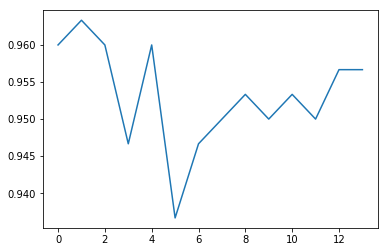

In [95]:
acc=[]
for i in range(len(accuracy)):
    if accuracy[i] > 0:
        acc.append(accuracy[i])

plt.plot(acc)
plt.show()